In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
from astropy import units as u

from astropy_healpix import HEALPix

### read data
nside = 64 ### spacing 0.9161 deg
disio=0.5
hpmapfname = "sxrbg_hpmap_ns%dr%d_ray.fits"%(nside, disio*100.0) ### power(cxb) + raymond(Gal. diffuse)
hdul = pyfits.open(hpmapfname)

hdu  = hdul[1]  ### unfolded photon flux
hdu2 = hdul[2]  ### model photon flux

#specdata = hdu.data.field(0)
#vedges  = np.linspace(0.1, 10.0, 1981)
vedges  = np.array([0.0843,
                    0.2033,
                    0.4214,
                    0.5205,
                    0.6989,
                    0.9071,
                    1.3135,
                    2.0074 ], np.float64)

vecen = (vedges[1:]+vedges[:-1])/2.0
vewid = (vedges[1:]-vedges[:-1])/2.0

nside    = hdu.header['NSIDE']
ordering = hdu.header['ORDERING']
#coordsys = hdu.header['COORDSYS']
coordsys = 'icrs' # fk5
hp = HEALPix(nside, ordering, coordsys)


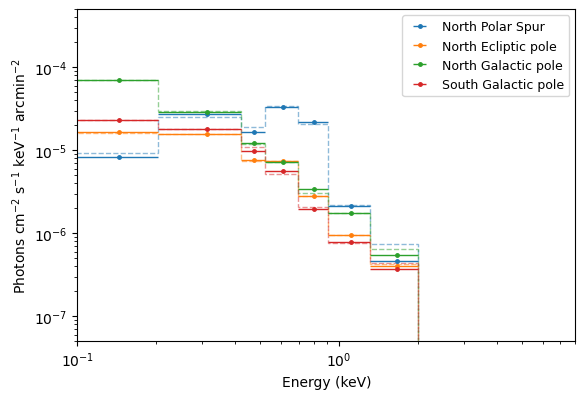

In [2]:
#### plot spectra
vradec = np.array([
    [260.587500, 4.756667],  ### North Polar Spur
    [272.800000, 66.000000], ### North Ecliptic pole
    [192.859481, 27.128251], ### North Galactic pole
    [12.859481, -27.128251], ### South Galactic pole
],'float64')

speclab_list = [
    "North Polar Spur   ",
    "North Ecliptic pole",
    "North Galactic pole",
    "South Galactic pole",
]

vskycoord = SkyCoord(vradec.T[0], vradec.T[1], frame=coordsys, unit='deg') 
#print(vskycoord)
vhpxidx = hp.skycoord_to_healpix(vskycoord)
#print(vhpxidx)

fig, ax = plt.subplots(figsize=(6,4))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.12, top=0.95)

ax.set_xlim(0.1, 8.)
ax.set_ylim(0.5e-7, 5.e-4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Photons cm$^{-2}$ s$^{-1}$ keV$^{-1}$ arcmin$^{-2}$')

nskycoord = len(vskycoord)
for idx in range(nskycoord) :
    hpxidx = vhpxidx[idx]
    #vspec  = specdata[hpxidx]
    vspunf  = hdu2.data[hpxidx]
    speclab = speclab_list[idx]
    ax.errorbar(vecen, vspunf, xerr=vewid, fmt='.', ms=5, lw=1, color='C%d'%(idx), label=speclab)

    vspmod  = hdu.data[hpxidx]
    ax.stairs(vspmod, vedges, lw=1, ls='dashed', color='C%d'%(idx), alpha=0.5)

ax.legend(loc='upper right', fontsize=9)


In [3]:
#### plot all-sky map    
from reproject import reproject_from_healpix, reproject_to_healpix
from astropy.visualization import make_rgb, make_lupton_rgb, LinearStretch, LogStretch

### wcs
coordsys = "galactic"
target_header = pyfits.Header.fromstring("""
NAXIS   =                    2
NAXIS1  =                  720
NAXIS2  =                  360
CTYPE1  = 'GLON-AIT'
CRPIX1  =                360.5
CRVAL1  =                  0.0
CDELT1  =               -0.5
CUNIT1  = 'deg     '
CTYPE2  = 'GLAT-AIT'
CRPIX2  =                180.5
CRVAL2  =                  0.0
CDELT2  =                0.5
CUNIT2  = 'deg     '
COORDSYS= 'icrs    '
""", sep='\n')
w  = wcs.WCS(target_header)

datatype = np.float64 #'float64' ### float32
ny = w.array_shape[0]
nx = w.array_shape[1]

### 3 band 
ebandgrp_list = [
    [1,2],
    [3,4],
    [5,6]
]

ebandtitle_list = [
    #"R23 (0.14-0.83 keV)",
    #"R45 (0.47-1.21 keV)",
    #"R67 (0.76-2.04 keV)",
    "R23 (0.20-0.52 keV)",
    "R45 (0.52-0.91 keV)",
    "R67 (0.91-2.00 keV)",
]

rgblist = [
    "red", "green", "blue"
]

rgbimglist = []

ngrp = len(ebandgrp_list)

for igrp in range(ngrp) :
    ebandgrp = ebandgrp_list[igrp]
    img = np.zeros((ny,nx), datatype)
    for ebandidx in ebandgrp :
        ebandle = vedges[ebandidx]
        ebandhe = vedges[ebandidx+1]
        hmap = hdu.data.field(ebandidx)
        array, footprint = reproject_from_healpix((hmap, 'icrs'), target_header,  
                                                   order='bilinear', nested=False)
        array = np.nan_to_num(array)
        array *= (array>0.0)
        array *= (ebandhe-ebandle) ### * (eband width)
        img += array 
    
    #zmax = img.max()
    #zmin = img.min()
    rgbimglist.append(img)
    

zmin, zmax =  4.410845989592182e-08 0.0007386311305829952
zmin, zmax =  3.564751703258992e-08 0.0003184556823638003
zmin, zmax =  6.2058598065809524e-09 7.478611558866672e-05


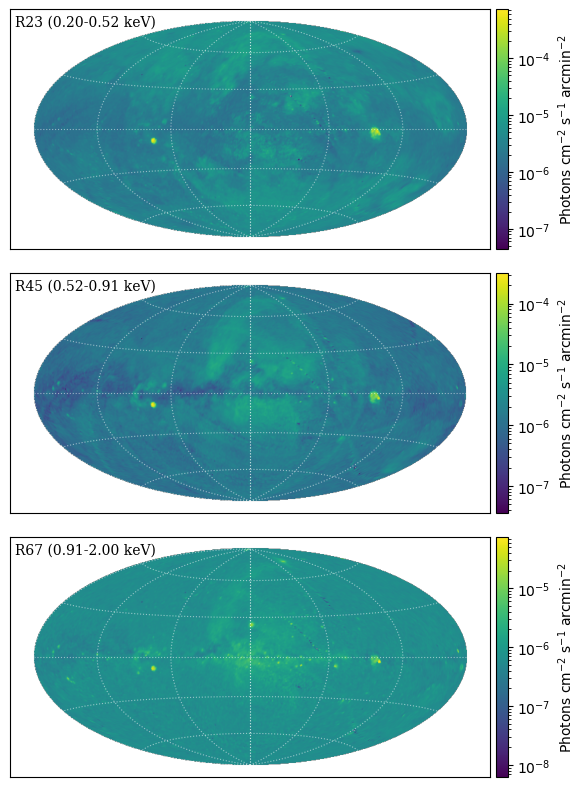

In [4]:
##### 3 band image #####
fig, axs = plt.subplots(3,1, figsize=(6,8), subplot_kw=dict(projection=w))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98, wspace=0.1, hspace=0.1)

colormap = 'viridis' ### default
#colormap = 'gray'

for idx in range(ngrp) :
    ax = axs[idx]
    imgdat = rgbimglist[idx]
    zmax = imgdat.max()
    zmin = ((imgdat<1e-20)*1+imgdat).min()
    print("zmin, zmax = ", zmin, zmax)
    im = axs[idx].imshow(imgdat, origin='lower',
                         #vmin=zmin, vmax=zmax,
                         norm='log', cmap=colormap)
    fig.colorbar(im, ax=ax, location='right', pad=0.01,
                 label = 'Photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$')
    
    lon = ax.coords['glon']
    lat = ax.coords['glat']
    lon.grid(color='white', alpha=0.5, linestyle='dotted')
    lon.set_ticks( np.linspace(0,360,7) * u.degree)
    lat.grid(color='white', alpha=0.5, linestyle='dotted')
    lat.set_ticks( np.linspace(-90,90,7) * u.degree)

    ebandtitle = ebandtitle_list[idx]
    ax.text(0.01, 0.93, ebandtitle,
            transform = ax.transAxes,
            fontsize=10, fontfamily='serif')

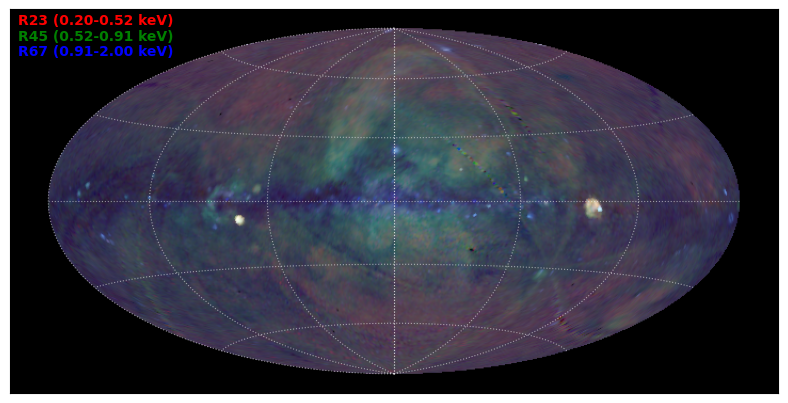

In [5]:
##### RGB image #####
fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(projection=w))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98, wspace=0.1, hspace=0.1)

rgbimg = make_rgb(rgbimglist[0], rgbimglist[1], rgbimglist[2], 
                  stretch=LogStretch(), output_dtype=datatype)
im = ax.imshow(rgbimg, origin='lower')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.grid(color='white', alpha=0.5, linestyle='dotted')
lon.set_ticks( np.linspace(0,360,7) * u.degree)
lat.grid(color='white', alpha=0.5, linestyle='dotted')
lat.set_ticks( np.linspace(-90,90,7) * u.degree)

ax.text(0.01, 0.96, ebandtitle_list[0], color=rgblist[0],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 
ax.text(0.01, 0.92, ebandtitle_list[1], color=rgblist[1],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 
ax.text(0.01, 0.88, ebandtitle_list[2], color=rgblist[2],
        transform = ax.transAxes, fontsize=10, fontweight='bold') 


plt.ion()
plt.show()